# Clean up existing features and engineer new ones

In [1]:
import dateutil
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder

pd.options.display.max_columns = 200

In [2]:
train = pd.read_csv('data/train.csv')
test  = pd.read_csv('data/test.csv')

In [3]:
df = pd.concat([train, test])
number_of_train_rows = train.shape[0]

In [4]:
display(
    train.shape,
    test.shape,
    df.shape,
)

(59400, 40)

(14850, 40)

(74250, 40)

In [5]:
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [6]:
df.dtypes

id                         int64
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

## Exploring the data

In [7]:
train_nulls = train.isnull().sum()
test_nulls = test.isnull().sum()

nulls = pd.concat([train_nulls[train_nulls != 0], test_nulls[test_nulls != 0]], axis=1)
nulls.columns = ['train', 'test']

nulls

,train,test
funder,3635,869
installer,3655,877
subvillage,371,99
public_meeting,3334,821
scheme_management,3877,969
scheme_name,28166,7092
permit,3056,737


In [8]:
suspect_features = [
    'funder',
    'installer',
    'wpt_name',
    'basin',
    'subvillage',
    'region',
    'region_code',
    'district_code',
    'lga',
    'ward',
    'recorded_by',
    'scheme_name',
]

print('Number of factor levels\n')
for f in suspect_features:
    print('{:5d} - {}'.format(df[f].value_counts().size, f))

Number of factor levels

 2140 - funder
 2410 - installer
45684 - wpt_name
    9 - basin
21425 - subvillage
   21 - region
   27 - region_code
   20 - district_code
  125 - lga
 2098 - ward
    1 - recorded_by
 2868 - scheme_name


In [9]:
features_to_drop = set([
    'wpt_name',    # too many factor levels
    'subvillage',  # too many factor levels and we have lat/long for the location
    'recorded_by', # constant
    'scheme_name', # too many NaNs
    'num_private', # irrelevant info
])

## Reduce factor levels

In [10]:
def reduce_factor_levels(df, column_name, min_count=700, other_name='Other'):
    counts = df[column_name].value_counts()
    top = counts[counts >= min_count].index
    df.loc[~df[column_name].isin(top), 'reduced_' + column_name] = other_name

In [11]:
reduce_factor_levels(df, 'funder')
reduce_factor_levels(df, 'installer')

## Extract new features from dates

In [12]:
features_to_drop.add('date_recorded')

In [13]:
df.date_recorded = pd.to_datetime(df.date_recorded, format='%Y-%m-%d')

In [14]:
df['year']  = df.date_recorded.dt.year
df['month'] = df.date_recorded.dt.month

In [15]:
is_zero_year = df['construction_year'] == 0
known_years = df[~is_zero_year]['construction_year']

med_year = int(known_years.median())
mean_year = int(known_years.mean())
min_year = known_years.min()
max_year = known_years.max()

min_year, mean_year, med_year, max_year

(1960, 1996, 2000, 2013)

In [16]:
df.loc[is_zero_year, 'construction_year'] = med_year
df['construction_period'] = df.construction_year // 5 - 196*2
df['estimated_age'] = df.year - df.construction_year
df['construction_year'] = df.construction_year - min_year

In [17]:
df.year.describe()

count    74250.000000
mean      2011.918559
std          0.960299
min       2001.000000
25%       2011.000000
50%       2012.000000
75%       2013.000000
max       2013.000000
Name: year, dtype: float64

In [18]:
df[['estimated_age', 'construction_year', 'construction_period']].describe()

,estimated_age,construction_year,construction_period
count,74250.000000,74250.000000,74250.000000
mean,13.953226,37.965333,7.345455
std,10.224527,10.142134,2.071650
min,-7.000000,0.000000,0.000000
25%,8.000000,36.000000,7.000000
50%,11.000000,40.000000,8.000000
75%,16.000000,44.000000,8.000000
max,53.000000,53.000000,10.000000


In [19]:
df['estimated_age'] += abs(df['estimated_age'].min())

## Clean up categorical features

In [20]:
def clean_values(df, col, values_dict):
    for k, v in values_dict.items():
        df.loc[df[col] == k, col] = v

In [21]:
def grouped_vc(df, by, counted_col):
    return pd.DataFrame(df.groupby(by)[counted_col].value_counts())

### Extraction type

In [22]:
grouped_vc(df, ['extraction_type_class','extraction_type_group'], 'extraction_type')

extraction_type
extraction_type_class extraction_type_group extraction_type                           
gravity               gravity               gravity                              33263
handpump              afridev               afridev                               2208
                      india mark ii         india mark ii                         3029
                      india mark iii        india mark iii                         135
                      nira/tanira           nira/tanira                          10205
                      other handpump        other - swn 81                         284
                                            other - play pump                      101
                                            walimi                                  60
                                            other - mkulima/shinyanga                2
                      swn 80                swn 80                                4588
motorpump             mono                  mono                                  3628
                      other motorpump       cemo                                   108
                                            climax                                  41
other                 other                 other                                 8102
rope pump             rope pump             other - rope pump                      572
submersible           submersible           submersible                           5982
                                            ksb                                   1790
wind-powered          wind-powered          windmill                               152

In [23]:
clean_values(df, 'extraction_type',
    {
        'india mark ii'             : 'india',
        'india mark iii'            : 'india',
        'other - swn 81'            : 'swn',
        'swn 80'                    : 'swn',
        'other - play pump'         : 'other handpump',
        'walimi'                    : 'other handpump',
        'other - mkulima/shinyanga' : 'other handpump',
        'cemo'                      : 'other motorpump',
        'climax'                    : 'other motorpump',
    }
)

In [24]:
features_to_drop.add('extraction_type_group')

In [25]:
grouped_vc(df, ['extraction_type_class'], 'extraction_type')

extraction_type
extraction_type_class extraction_type                   
gravity               gravity                      33263
handpump              nira/tanira                  10205
                      swn                           4872
                      india                         3164
                      afridev                       2208
                      other handpump                 163
motorpump             mono                          3628
                      other motorpump                149
other                 other                         8102
rope pump             other - rope pump              572
submersible           submersible                   5982
                      ksb                           1790
wind-powered          windmill                       152

### Management

In [26]:
grouped_vc(df, ['management_group'], 'management')

management
management_group management                  
commercial       private operator        2504
                 water authority         1123
                 company                  859
                 trust                    105
other            other                   1083
                 other - school           126
parastatal       parastatal              2229
unknown          unknown                  683
user-group       vwc                    50624
                 wug                     8108
                 water board             3688
                 wua                     3118

In [27]:
df.scheme_management.fillna('Unknown', inplace=True)

In [28]:
df.scheme_management.value_counts()

VWC                 45917
WUG                  6496
Unknown              4846
Water authority      3975
WUA                  3551
Water Board          3462
Parastatal           2124
Company              1341
Private operator     1326
Other                 996
SWC                   123
Trust                  92
None                    1
Name: scheme_management, dtype: int64

In [29]:
df.loc[df.scheme_management == 'None', 'scheme_management'] = 'Unknown'

### Quality

In [30]:
grouped_vc(df, ['quality_group'], 'water_quality')

water_quality
quality_group water_quality                    
colored       coloured                      623
fluoride      fluoride                      244
              fluoride abandoned             23
good          soft                        63505
milky         milky                        1005
salty         salty                        6082
              salty abandoned               423
unknown       unknown                      2345

In [31]:
features_to_drop.add('quality_group')

### Source

In [32]:
grouped_vc(df, ['source_class', 'source_type'], 'source')

source
source_class source_type          source                      
groundwater  borehole             machine dbh            13822
                                  hand dtw                1108
             shallow well         shallow well           21140
             spring               spring                 21216
surface      dam                  dam                      840
             rainwater harvesting rainwater harvesting    2863
             river/lake           river                  11964
                                  lake                     950
unknown      other                other                    261
                                  unknown                   86

In [33]:
df.loc[df['source'] == 'other', 'source'] = 'unknown'

In [34]:
features_to_drop.add('source_type')

### Waterpoint

In [35]:
grouped_vc(df, ['waterpoint_type_group'], 'waterpoint_type')

waterpoint_type
waterpoint_type_group waterpoint_type                             
cattle trough         cattle trough                            150
communal standpipe    communal standpipe                     35628
                      communal standpipe multiple             7611
dam                   dam                                        8
hand pump             hand pump                              21884
improved spring       improved spring                          959
other                 other                                   8010

In [36]:
features_to_drop.add('waterpoint_type_group')

### Payment

In [37]:
grouped_vc(df, ['payment_type'], 'payment')

,,payment
payment_type,payment,
annually,pay annually,4570
monthly,pay monthly,10397
never pay,never pay,31712
on failure,pay when scheme fails,4842
other,other,1314
per bucket,pay per bucket,11266
unknown,unknown,10149


In [38]:
features_to_drop.add('payment')

### Quantity

In [39]:
grouped_vc(df, ['quantity_group'], 'quantity')

,,quantity
quantity_group,quantity,
dry,dry,7782
enough,enough,41522
insufficient,insufficient,18896
seasonal,seasonal,5075
unknown,unknown,975


In [40]:
features_to_drop.add('quantity_group')

In [41]:
grouped_vc(df, ['quality_group'], 'water_quality')

water_quality
quality_group water_quality                    
colored       coloured                      623
fluoride      fluoride                      244
              fluoride abandoned             23
good          soft                        63505
milky         milky                        1005
salty         salty                        6082
              salty abandoned               423
unknown       unknown                      2345

In [42]:
features_to_drop.add('quality_group')

### Location info

In [43]:
grouped_vc(df, ['region', 'lga'], 'ward').head(30)

ward
region lga          ward              
Arusha Arusha Rural Nduruma        244
                    Olkokola       163
                    Kiranyi        139
                    Mlangarini     111
                    Ilkiding'a     104
                    Oldonyosambu    97
                    Kimnyaki        93
                    Oltroto         87
                    Oltrumet        62
                    Moshono         57
                    Sokoni II       54
                    Moivo           52
                    Bwawani         46
                    Bangata         43
                    Murieti         38
                    Kisongo         37
                    Musa            29
                    Mateves         28
                    Mwandeti        24
                    Oljoro          13
       Arusha Urban Elerai          14
                    Terrat          11
                    Sokon I          7
                    Unga Ltd         7
                    Kaloleni         5
                    Lemara           5
                    Ngarenaro        5
                    Sekei            5
                    Baraa            4
                    Kimandolu        4

 - __*region_code*__ seems to be a proxy for a __*region*__
 - __*region_code combined with district_code*__ seems to be a proxy for an __*lga*__

So I'll keep all geo info and try 3 options:
  1. __region__ / __lga__ / __ward__
  2. __region_code__ / __region_code__*100 + __district_code__ / __ward__ (this is more precise)
  3. __region__ / __lga__ / __longitude__ / __latitude__ (this is the most precise)

In [44]:
df['district_code'] = (df['region_code'] * 100 + df['district_code']).astype(str)

In [45]:
def impute_mean_geo(df, col):
    has_value = df[col] != 0
    
    mean_dis = df[has_value].groupby(['district_code'])[col].mean()
    mean_reg = df[has_value].groupby(['region_code'])[col].mean()
    
    df.loc[~has_value, col] = df[~has_value]['district_code']\
        .apply(lambda x: mean_dis[x] if x in mean_dis.index else 0)
    df.loc[~has_value, col] = df[~has_value]['region_code']\
        .apply(lambda x: mean_reg[x] if x in mean_reg.index else 0)

In [46]:
impute_mean_geo(df, 'latitude')
impute_mean_geo(df, 'longitude')

In [47]:
df[['latitude', 'longitude']].describe()

,latitude,longitude
count,7.425000e+04,74250.000000
mean,-5.701771e+00,35.088400
std,2.944969e+00,2.590925
min,-1.164944e+01,29.607122
25%,-8.525675e+00,33.234470
50%,-5.026540e+00,34.907475
75%,-3.325058e+00,37.181685
max,-2.000000e-08,40.345193


## Remaining features

In [48]:
df['amount_tsh'].describe()

count     74250.000000
mean        318.685704
std        2906.762364
min           0.000000
25%           0.000000
50%           0.000000
75%          20.000000
max      350000.000000
Name: amount_tsh, dtype: float64

In [50]:
features_to_drop.add('amount_tsh')

In [51]:
df.loc[df.population == 0].shape

(26834, 46)

In [52]:
df.loc[df.population == 0, 'population'] = df.population.median()

In [53]:
df.fillna('Unknown', inplace=True)
objects = df.select_dtypes(include=['O']).columns.values
df[objects] = df[objects].apply(lambda x: x.astype(str).str.lower())

## Drop useless

In [54]:
df.drop(features_to_drop, axis=1, inplace=True)

## Write to csv

In [55]:
df[0:number_of_train_rows].to_csv('cleaned/train.csv', index=False)
df[number_of_train_rows:].to_csv('cleaned/test.csv', index=False)

In [56]:
df.columns.tolist()

['id',
 'funder',
 'gps_height',
 'installer',
 'longitude',
 'latitude',
 'basin',
 'region',
 'region_code',
 'district_code',
 'lga',
 'ward',
 'population',
 'public_meeting',
 'scheme_management',
 'permit',
 'construction_year',
 'extraction_type',
 'extraction_type_class',
 'management',
 'management_group',
 'payment_type',
 'water_quality',
 'quantity',
 'source',
 'source_class',
 'waterpoint_type',
 'reduced_funder',
 'reduced_installer',
 'year',
 'month',
 'construction_period',
 'estimated_age']

In [57]:
df.columns.size

33

In [58]:
df.head(3)

,id,funder,gps_height,installer,longitude,latitude,basin,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_class,management,management_group,payment_type,water_quality,quantity,source,source_class,waterpoint_type,reduced_funder,reduced_installer,year,month,construction_period,estimated_age
0,69572,roman,1390,roman,34.938093,-9.856322,lake nyasa,iringa,11,1105,ludewa,mundindi,109.0,true,vwc,false,39,gravity,gravity,vwc,user-group,annually,soft,enough,spring,groundwater,communal standpipe,other,other,2011,3,7,19
1,8776,grumeti,1399,grumeti,34.698766,-2.147466,lake victoria,mara,20,2002,serengeti,natta,280.0,unknown,other,true,50,gravity,gravity,wug,user-group,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,other,other,2013,3,10,10
2,34310,lottery club,686,world vision,37.460664,-3.821329,pangani,manyara,21,2104,simanjiro,ngorika,250.0,true,vwc,true,49,gravity,gravity,vwc,user-group,per bucket,soft,enough,dam,surface,communal standpipe multiple,other,other,2013,2,9,11


## Visualization

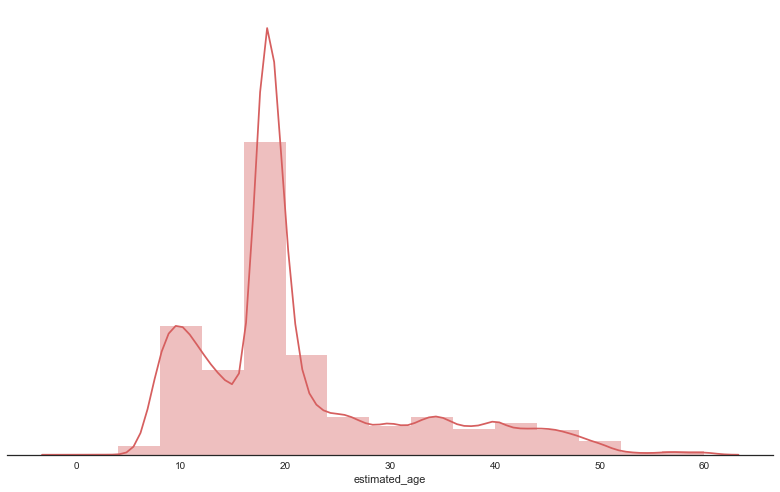

In [111]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.despine(left=True)
sns.distplot(df.estimated_age, axlabel='estimated_age', bins=15, color="r")
plt.setp(axes, yticks=[])
plt.tight_layout()

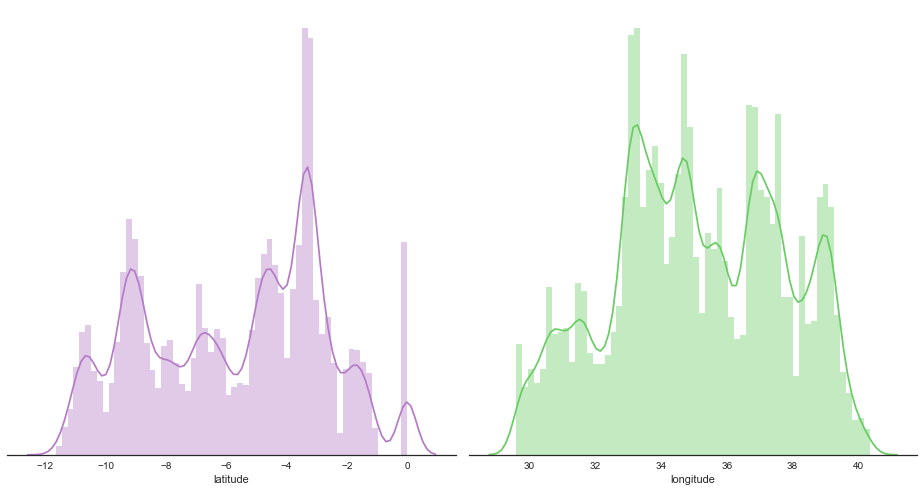

In [130]:
f, axes = plt.subplots(ncols=2, figsize=(13, 7))
sns.despine(left=True)
sns.distplot(df.latitude,  label='latitude',  color="m", bins=60, ax=axes[0])
sns.distplot(df.longitude, label='longitude', color="g", bins=60, ax=axes[1])
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()